In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

%matplotlib inline

import bioframe
from bioframe.tools import tsv
from bioframe.tools import bedtools

In [146]:
# ls dots
s1 = "./dots/final_cloops_U54-ESC4DN-FA-DpnII-2017524-R1.5000-10000.bedpe"
s2 = "./dots/final_cloops_U54-ESC4DN-FA-DpnII-2017524-R2.5000-10000.bedpe"
s12 = "./dots/final_cloops_U54-ESC4DN-FA-DpnII-2017524-R1-R2.5000-10000.bedpe"

h1 = "./dots/final_cloops_U54-HFFc6-p17-FA-DpnII-20170327_hg38.5000-10000.bedpe"
h2 = "./dots/final_cloops_U54-HFFc6-p22-FA-DpnII-20170327_hg38.5000-10000.bedpe"
h12 = "./dots/final_cloops_U54-HFFc6-p17-p22-FA-DpnII-20170327_hg38.5000-10000.bedpe"

ds12 = pd.read_table(s12)
dh12 = pd.read_table(h12)

chroms = ds12["chrom1"].unique()

ds12.head()

,chrom1,start1,end1,chrom2,start2,end2,obs.raw,cstart1,cstart2,c_label,c_size,la_exp.donut.value,la_exp.vertical.value,la_exp.horizontal.value,la_exp.lowleft.value
0,chr1,880000,890000,chr1,5650000,5660000,15,880000.0,5650000.0,0,1,0.443206,0.516720,0.705974,0.405552
1,chr1,1380000,1385000,chr1,1485000,1490000,49,1380000.0,1482500.0,2,2,20.022349,19.268067,21.153967,20.795501
2,chr1,1770000,1775000,chr1,8795000,8800000,114,1770000.0,8795000.0,3,1,0.155446,0.125364,0.050897,0.165955
3,chr1,1960000,1970000,chr1,2040000,2050000,346,1937000.0,2032000.0,9,10,170.640167,187.783053,179.274821,167.036607
4,chr1,3900000,3910000,chr1,4590000,4600000,59,3900000.0,4590000.0,22,1,23.507903,25.599774,30.460090,27.342046


In [147]:
# ls supplement_tracks/
ctcf = pd.read_table("./supplement_tracks/CTCF_motif_Kim_hg38_calculatedodds.bed.simple.bed",
                       names=['chrom','start','end','name','strength','direction'])

# let's sort it and filter relevant chroms only at first:
ctcf = ctcf[ctcf['chrom'].isin(chroms)].sort_values(by=['chrom','start'])

# some column name groups for future use:
c=["chrom","start","end"]
c1=["chrom1","start1","end1"]
c2=["chrom2","start2","end2"]
c_ctcf = ["chrom","start","end","direction"]

# print ctcf head
ctcf.head()

,chrom,start,end,name,strength,direction
15,chr1,11223,11242,Kim_etal_PWM_CTCF_bindingMotif,17.489608,-
16,chr1,11281,11300,Kim_etal_PWM_CTCF_bindingMotif,16.047339,-
54,chr1,23873,23892,Kim_etal_PWM_CTCF_bindingMotif,10.000023,-
135,chr1,79647,79666,Kim_etal_PWM_CTCF_bindingMotif,9.962903,+
154,chr1,91419,91438,Kim_etal_PWM_CTCF_bindingMotif,8.157868,+


In [148]:
# need to create a dataframe of dots-bases
# first concat lest and right sides of the BEDPE file:
dotanchors = pd.concat([
                ds12[cn].rename( # need to rename columns same way to concat:
                     columns={_cn:_c for _c,_cn in zip(c,cn)}) \
                        for cn in [c1,c2]])

dotanchors = dotanchors.sort_values(by=['chrom','start'])

with tsv(dotanchors) as _s:
    o = bedtools.merge(i=_s.name, d=10000)
    o.columns = c

dotanchors = o
print("{} dots are formed by {} unique anchros, factor: {}" \
          .format(len(ds12),len(dotanchors),len(dotanchors)/len(ds12)))

5842 dots are formed by 8787 unique anchros, factor: 1.5041081821294078


In [149]:
# bed-intersect dots bases with CTCF ...

# # Example on how to work with bedtools wrapper from bioframe ...
# # use tsv - that creates temporary tsv-files from dataframes on the fly ...
with tsv(dotanchors) as _s, tsv(ctcf[c_ctcf]) as _c:
    o = bedtools.intersect(a=_s.name, b=_c.name, wa=True,wb=True)
    o.columns = c + c_ctcf

print("{} of anchors have a CTCF-motif inside, out of {}, fraction: {}"\
          .format(len(o),len(dotanchors),len(o)/len(dotanchors)))
    

4295 of anchors have a CTCF-motif inside, out of 8787, fraction: 0.48879025833617845


In [150]:
# bed-intersect dots with CTCF, left and right side separately ...

# # Example on how to work with bedtools wrapper from bioframe ...
# # use tsv - that creates temporary tsv-files from dataframes on the fly ...
with tsv(ds12[c1]) as s, tsv(ctcf[c_ctcf]) as c:
    o1 = bedtools.intersect(a=s.name, b=c.name, wa=True,wb=True)
    o1.columns = c1 + c_ctcf
with tsv(ds12[c2]) as s, tsv(ctcf[c_ctcf]) as c:
    o2 = bedtools.intersect(a=s.name, b=c.name, wa=True,wb=True)
    o2.columns = c2 + c_ctcf

# let's just look at the intersections ...
display(o2.head(2))
display(o1.head(2))

,chrom2,start2,end2,chrom,start,end,direction
0,chr1,2040000,2050000,chr1,2043558,2043577,-
1,chr1,2040000,2050000,chr1,2044993,2045012,-


,chrom1,start1,end1,chrom,start,end,direction
0,chr1,1960000,1970000,chr1,1960215,1960234,+
1,chr1,1960000,1970000,chr1,1968508,1968527,-


In [151]:
# merge original bedpe with the results of intersection on both sides ...
ds12_dd = ds12.merge(o1,how='outer',on=c1)[c1+c2+['direction']] \
              .merge(o2,how='outer',on=c2)[c1+c2+['direction_x','direction_y']]
# bedtools.intersect?
ds12_dd.head(5)

,chrom1,start1,end1,chrom2,start2,end2,direction_x,direction_y
0,chr1,880000,890000,chr1,5650000,5660000,NaN,NaN
1,chr1,1380000,1385000,chr1,1485000,1490000,NaN,NaN
2,chr1,1770000,1775000,chr1,8795000,8800000,NaN,NaN
3,chr1,1960000,1970000,chr1,2040000,2050000,+,-
4,chr1,1960000,1970000,chr1,2040000,2050000,+,-


In [152]:

# let's drop dots that have a CTCF motif at least in one of the anchors ...
ds12_ctcf = ds12_dd.dropna(how='all',subset=["direction_x","direction_y"])
# group by the dots again:
grp = ds12_ctcf.groupby(by=c1+c2)
# count groups, i.e. dots ...
print("{} dots have CTCF motif at least in one of the anchors, out of {} dots total: {}".format(len(grp),
                                                                                  len(ds12),
                                                                                  len(grp)/len(ds12) )
     )

# let's drop dots that does not have a CTCF motif in either of the anchors ...
ds12_ctcf = ds12_dd.dropna()
# group by the dots again:
grp = ds12_ctcf.groupby(by=c1+c2)
# count groups, i.e. dots ...
print("{} dots have CTCF motif in both anchors, out of {} dots total: {}".format(len(grp),
                                                                              len(ds12),
                                                                              len(grp)/len(ds12) )
     )

3197 dots have CTCF motif at least in one of the anchors, out of 5842 dots total: 0.547244094488189
899 dots have CTCF motif in both anchors, out of 5842 dots total: 0.15388565559739814


In [153]:
# let's select only those dots that have 1 CTCF motif per anchor
idx = np.concatenate([i for g,i in grp.groups.items() if len(i)==1])
# for those let's calculate directionality combinations:
ds12_dd.loc[idx].groupby(['direction_x',"direction_y"]).size()/len(ds12_dd.loc[idx])

direction_x  direction_y
+            +              0.147132
             -              0.700748
-            +              0.039900
             -              0.112219
dtype: float64

Text(0.5,0,'# of CTCF motif per dot')

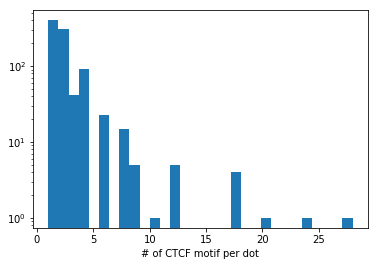

In [154]:
_ = plt.hist(grp.size(),bins=30,log=1)
ax = plt.gca()
ax.set_xlabel("# of CTCF motif per dot")